# Исследование пользователей сервиса аренды самокатов GoFast

<b>Данные представляют собой сведения о некоторых пользователях сервиса из нескольких городов, а также об их поездках и тарифах.<b><br>
<b>Цель работы<b>: проанализировать предоставленные данные и проверить некоторые гипотезы для помощи бизнесу.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

### Загрузка данных

In [2]:
try:
    users = pd.read_csv('users_go.csv')
    rides = pd.read_csv('rides_go.csv')
    subscriptions = pd.read_csv('subscriptions_go.csv')
except:
    users = pd.read_csv('/datasets/users_go.csv')
    rides = pd.read_csv('/datasets/rides_go.csv')
    subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
display(users.head(), users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


None

Описание данных в таблице `users`:
* `user_id` - уникальный идентификатор пользователя;
* `name` - имя пользователя;
* `age` - возраст;
* `city` - город;
* `subscription_type` - тип подписки (free, ultra).

In [4]:
display(rides.head(), rides.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


None

Описание данных в таблице `rides`:
* `user_id` - уникальный идентификатор пользователя;
* `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах);
* `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»;
* `date` - дата совершения поездки.

Столбец `date` содержит данные типа `object`, а не `datetime`. Исправим это на следующем этапе.

In [5]:
display(subscriptions.head(), subscriptions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


None

Описание данных в таблице `subscriptions`:
* `subscription_type` - тип подписки;
* `minute_price` - стоимость одной минуты поездки по данной подписке;
* `start_ride_price` - стоимость начала поездки;
* `subscription_fee` - стоимость ежемесячного платежа.

### Предобработка данных

На этапе предобработки данных приведём данные к нужным типам в местах, где это требуется и избавимся от пропусков и дубликатов.

In [6]:
rides['date'] = pd.to_datetime(rides['date'], format='%Y-%m-%d')

rides['date'].head()

0   2021-01-01
1   2021-01-18
2   2021-04-20
3   2021-08-11
4   2021-08-28
Name: date, dtype: datetime64[ns]

In [7]:
rides.dtypes

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

In [8]:
rides['month'] = rides['date'].dt.month

rides[['date', 'month']].head()

,date,month
0,2021-01-01,1
1,2021-01-18,1
2,2021-04-20,4
3,2021-08-11,8
4,2021-08-28,8


In [9]:
def remove_duplicates(data):
    num_of_duplicates = data.duplicated().sum()
    print(f'Количество дубликатов до удаления: {num_of_duplicates}.')
    if num_of_duplicates:
        data = data.drop_duplicates().reset_index(drop=True)
        print(f'Количество дубликатов после удаления: {data.duplicated().sum()}.')
    print()

In [10]:
for data in [users, subscriptions, rides]:
    remove_duplicates(data)

Количество дубликатов до удаления: 31.
Количество дубликатов после удаления: 0.

Количество дубликатов до удаления: 0.

Количество дубликатов до удаления: 0.



Проверим столбец с названиями городов на наличие неявных дубликатов.

In [11]:
users['city'].unique()

array(['Тюмень', 'Омск', 'Москва', 'Ростов-на-Дону', 'Краснодар',
       'Пятигорск', 'Екатеринбург', 'Сочи'], dtype=object)

In [12]:
users.isna().sum()

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [13]:
rides.isna().sum()

user_id     0
distance    0
duration    0
date        0
month       0
dtype: int64

In [14]:
subscriptions.isna().sum()

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Мы привели столбец `date` датафрейма `rides` к типу `datetime`, а также избавились от явных дубликатов в датафрейме `users`.

### Исследовательский анализ данных

На этом этапе изучим общую информацию о пользователях и поездках:
* частота встречаемости городов;
* соотношение пользователей с подпиской и без подписки;
* возраст пользователей;
* расстояние, которое пользователь преодолел за одну поездку;
* продолжительность поездок.

Частоту встречаемости городов рассмотрим относительно двух разных величин:
* количество пользователей для каждого города;
* количество поездок для каждого города.

Для визуализации распределений воспользуемся столбчатой диаграммой.

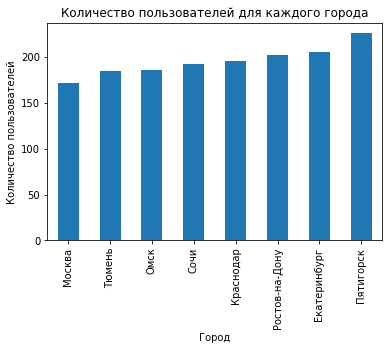

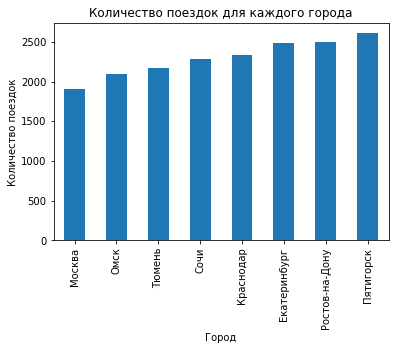

In [15]:
users['city'].value_counts(ascending=True).plot.bar(ylabel='Количество пользователей', xlabel='Город')
plt.title('Количество пользователей для каждого города')
plt.show()

(users[['user_id', 'city']].merge(rides['user_id']).groupby('city').count().sort_values(by='user_id')
 .plot.bar(legend=False, ylabel='Количество поездок', xlabel='Город'))
plt.title('Количество поездок для каждого города')
plt.show()

Как ни странно, наименьшее количество поездок совершено пользователями из `Москвы`. Наименьшее количество пользователей также в `Москве`, а наибольшее количество поездок совершено наибольшим количеством пользователей из `Пятигорска`. Можно заметить, что количество пользователей прямо пропорционально количеству поездок, скорее всего, все пользователи совершают примерно одинаковое количество поездок.

Теперь посчитаем соотношение пользователей с подпиской и без подписки.

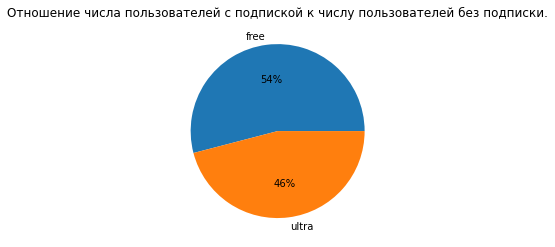

Число пользователей с подпиской: 719
Число пользователей без подписки: 846
Отношение числа пользователей с подпиской к числу пользователей без подписки равно 0.84988


In [16]:
users_with_subscription_cnt = users.query('subscription_type == "ultra"')['user_id'].count()
users_without_subscription_cnt = users.query('subscription_type == "free"')['user_id'].count()

users.groupby('subscription_type')['user_id'].count().plot(kind='pie', ylabel='', autopct='%1.0f%%')
plt.title('Отношение числа пользователей с подпиской к числу пользователей без подписки.')
plt.show()

print(f'Число пользователей с подпиской: {users_with_subscription_cnt}')
print(f'Число пользователей без подписки: {users_without_subscription_cnt}')
print(f'Отношение числа пользователей с подпиской к числу пользователей без подписки равно {users_with_subscription_cnt / users_without_subscription_cnt:.5f}')

Пользователей без подписки больше.

Теперь посмотрим на распределение количества пользователей по возрасту.

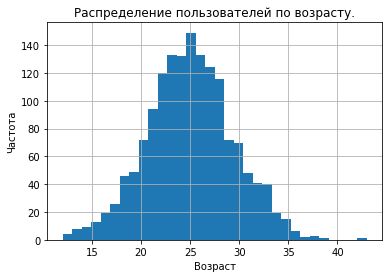

In [17]:
users['age'].hist(bins=32)
plt.title('Распределение пользователей по возрасту.')
plt.ylabel('Частота')
plt.xlabel('Возраст')
plt.show()

In [18]:
users['age'].describe()

count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

Наиболее распространённый возраст среди пользователей - от `20` до `30` лет, наименее распространённый - `43` года.

Посмотрим на распределение расстояния и длительности поездок.

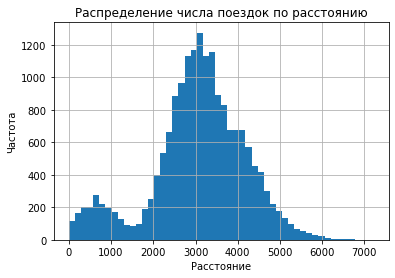

In [19]:
rides['distance'].plot.hist(bins=50, grid=True)
plt.title('Распределение числа поездок по расстоянию')
plt.ylabel('Частота')
plt.xlabel('Расстояние')
plt.show()

Распределение близко к нормальному. Большинство поездок совершаются на расстояние чуть более `3` километров. Также можно отметить пик для расстояния `~600` метров, видимо это более востребованное расстояние чем `~1.5` километра, где наблюдается локальный минимум.

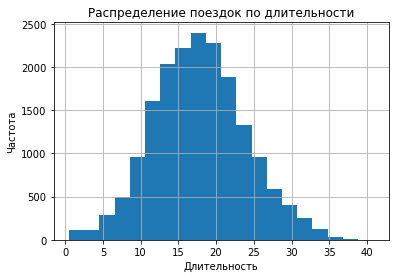

In [20]:
rides['duration'].hist(bins=20)
plt.title('Распределение поездок по длительности')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.show()

Рассмотрим поездки, которые длились меньше минуты.

In [21]:
rides.query('duration < 1')['duration'].value_counts()

0.5    95
Name: duration, dtype: int64

Все такие поездки имеют одинаковую продолжительность, скорее всего это ошибочные данные, которые можно удалить особых без потерь, так как таких поездок всего `95`. 
<br>
Навсякий случай, проверим, какой процент исходных данных останется после исключения этих поездок.

In [22]:
size_before = rides.shape[0]
rides = rides.query('duration >= 1')
display(rides.query('duration < 1'))
print(f'{rides.shape[0] / size_before:.2%}')

,user_id,distance,duration,date,month


99.47%


Построим распределение для обновлённых данных.

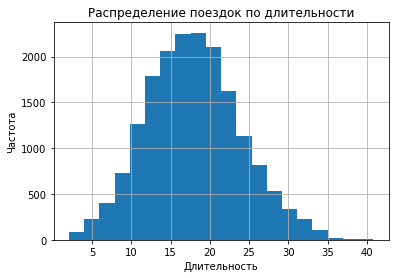

In [23]:
rides['duration'].hist(bins=20)
plt.title('Распределение поездок по длительности')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.show()

Распределение близко к нормальному, самое популярное время поездки - `~17 минут`.

Подытожим результаты, полученные выше.
* Наиболее часто встречаемый город в данных - `Пятигорск`, наименее - `Москва`;
* Отношение числа пользователей с подпиской к числу пользователей без подписки приблизительно равно `0.83713`;
* Наиболее распространённый возраст среди пользователей - от `20` до `30 лет`, наименее распространённый - `43` года;
* Большинство поездок совершаются на расстояние чуть более `3 километров`;
* Самое распространённое время поездки - `~17 минут`.

### Объединение данных

Объединим все данные в один датафрейм, из созданного датафрейма выделим ещё два:
* c данными о пользователях без подписки;
* с данными о пользователях с подпиской.

Исследуем информацию о расстоянии и времени поездок для пользователей обеих категорий.

In [24]:
full_data = users.merge(rides).merge(subscriptions).drop_duplicates().reset_index(drop=True)

if full_data.shape == (rides.shape[0], users.shape[1] + rides.shape[1] + subscriptions.shape[1] - 2):
    print('Объединение прошло успешно.')
else:
    print('При объединении произошла ошибка.')
    
full_data

Объединение прошло успешно.


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...
17968,1534,Альберт,25,Краснодар,free,3781.098080,19.822962,2021-11-04,11,8,50,0
17969,1534,Альберт,25,Краснодар,free,2840.423057,21.409799,2021-11-16,11,8,50,0
17970,1534,Альберт,25,Краснодар,free,3826.185507,18.435051,2021-11-18,11,8,50,0
17971,1534,Альберт,25,Краснодар,free,2902.308661,16.674362,2021-11-27,11,8,50,0


In [25]:
full_data_without_subscription = full_data.query('subscription_type == "free"')
full_data_with_subscription = full_data.query('subscription_type == "ultra"')

Для визуализации распределений расстояния и длительности воспользуемся гистограммами и разместим их на одном окне для большей наглядности.

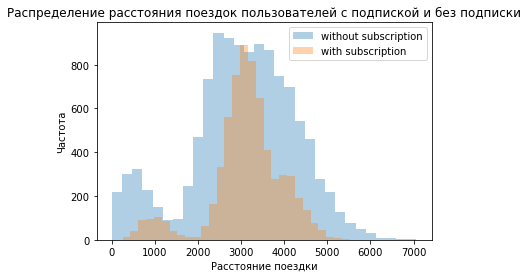

In [26]:
plt.hist(full_data_without_subscription['distance'], label='without subscription', alpha=0.35, bins=30)
plt.hist(full_data_with_subscription['distance'], label='with subscription', alpha=0.35, bins=30)
plt.title('Распределение расстояния поездок пользователей с подпиской и без подписки')
plt.xlabel('Расстояние поездки')
plt.ylabel('Частота')
plt.legend()
plt.show()

Оба распределения имеют схожую форму, оба близки к нормальному и имеют локальный максимум слева от "колокола". Отметим, что в среднем пользователи без подписки совершают поездки на большие расстояния, чем пользователи с подпиской.

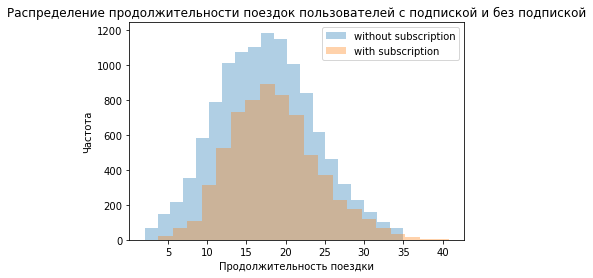

In [27]:
plt.hist(full_data_without_subscription['duration'], label='without subscription', alpha=0.35, bins=20)
plt.hist(full_data_with_subscription['duration'], label='with subscription', alpha=0.35, bins=20)
plt.title('Распределение продолжительности поездок пользователей с подпиской и без подпиской')
plt.ylabel('Частота')
plt.xlabel('Продолжительность поездки')
plt.legend()
plt.show()

Ситуация схожа с предыдущей, в этом случае пользователи без подписки в основном совершают более длительные поездки, чем пользователи с подпиской.

Распределения расстояния и времени поездок для пользователей обеих категорий имеют схожие распределения, близкие к нормальному. В среднем пользователи без подписки совершают поездки на большие расстояния и более длительные, чем пользователи с подпиской.

### Подсчёт выручки

На этом этапе посчитаем помесячную выручку, которую принёс каждый пользователь.

Создадим сводную таблицу по идентификатору пользователя и месяцу со следующими столбцами:
* `distance` - суммарное расстояние поездок пользователя за месяц;
* `rides` - число поездок пользователя за месяц;
* `duration` - суммарная длительность поездок пользователя за месяц.

In [28]:
pivot = full_data.groupby(['user_id', 'month']).agg({
    'distance': 'sum', 
    'name': 'count', 
    'duration': 'sum'
})
pivot = pivot.rename(columns={'name': 'rides'})
pivot['duration'] = np.ceil(pivot['duration']).astype('int')
pivot

distance  rides  duration
user_id month                               
1       1       7027.511294      2        42
        4        754.159807      1         7
        8       6723.470560      2        45
        10      5809.911100      2        32
        11      7003.499363      3        54
...                     ...    ...       ...
1534    6       3409.468534      2        25
        8       7622.453034      2        48
        9       4928.173852      1        23
        11     13350.015305      4        77
        12      2371.711192      1        16

[11300 rows x 3 columns]

Добавим в эту таблицу столбец с помесячной выручкой для каждого пользователя.

In [29]:
def get_revenue(row):    
    subscription_type = users[users['user_id'] == row.name[0]]['subscription_type'].iloc[0]
    subscription_data = subscriptions[subscriptions['subscription_type'] == subscription_type]
    return (
        (subscription_data['start_ride_price'] * row['rides']
        + subscription_data['minute_price'] * row['duration']
        + subscription_data['subscription_fee']).iloc[0]
    )
pivot['revenue'] = pivot.apply(get_revenue, axis=1)
pivot.head(25)

distance  rides  duration  revenue
user_id month                                        
1       1       7027.511294      2        42    451.0
        4        754.159807      1         7    241.0
        8       6723.470560      2        45    469.0
        10      5809.911100      2        32    391.0
        11      7003.499363      3        54    523.0
        12      6751.629942      2        28    367.0
2       3      10187.723006      3        61    565.0
        4       6164.381824      2        40    439.0
        6       3255.338202      1        14    283.0
        7       6780.722964      2        47    481.0
        8        923.007439      1         7    241.0
        10      2824.636598      1        19    313.0
        12      3828.248580      1        12    271.0
3       1       3061.777147      1        13    277.0
        2       5421.152016      2        38    427.0
        4       2956.651632      1        21    325.0
        5       9064.026918      3        62    571.0
        7      10919.595403      3        66    595.0
        9       2891.012822      1        23    337.0
        12      2593.381928      1        13    277.0
4       2       6339.696747      2        49    493.0
        6       6753.041806      2        44    463.0
        7      10491.175555      3        56    535.0
        8       4649.488243      1        36    415.0
        10     13260.762274      4        78    667.0

Посмотрим на распределение значений помесячной выручки. <br>
Узнаем среднюю, минимальную и максимальную выручку с пользователя за месяц.

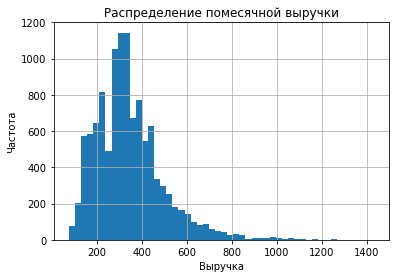

count    11300.000000
mean       340.565575
std        150.568495
min         74.000000
25%        234.000000
50%        319.000000
75%        412.000000
max       1428.000000
Name: revenue, dtype: float64

In [30]:
pivot['revenue'].hist(bins=50)
plt.title('Распределение помесячной выручки')
plt.ylabel('Частота')
plt.xlabel('Выручка')
plt.show()

pivot['revenue'].describe()

Большого числа выбросов нет, есть лишь небольшое количество значений, заметно отличающихся от общей массы. 
* Средняя выручка с одного пользователя за месяц приблизительно равна `~340.6 руб.`;
* Минимальная - `74 руб.`;
* Максимальная - `1428 руб.`.

Теперь посмотрим на общую прибыль за каждый месяц.

In [31]:
pivot.groupby('month')['revenue'].sum().sort_values()

month
2     288330.0
11    303086.0
10    312946.0
4     320370.0
9     320631.0
8     323068.0
12    323351.0
7     326064.0
3     327106.0
6     333556.0
5     334525.0
1     335358.0
Name: revenue, dtype: float64

Наиболее прибыльный месяц - `январь`, наименее прибыльный - `февраль`. 

Мы создали сводную таблицу, рассчитали помесячную выручку для каждого пользователя, провели небольшой анализ полученных значений.<br>
В результате получили следующее:
* Средняя помесячная выручка с одного пользователя - `~340.6 руб.`;
* Минимальная помесячная выручка с одного пользователя - `74 руб.`;
* Максимальная помесячная выручка с одного пользователя - `1428 руб.`;
* Наиболее прибыльный месяц - `январь`;
* Наименее прибыльный месяц - `февраль`.

### Проверка гипотез

Необходимо  проверить следующие гипотезы:
* Тратят ли пользователи с подпиской больше времени на поездки?
* Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает `3130 метров`?
* Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

И ответить на вопрос: "Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?"

Проверим первую гипотезу.
<br>
Сформулируем нулевую гипотезу `H0` - пользователи с подпиской тратят на поездки столько же времени, сколько пользователи без подписки. Альтернативная гипотеза `H1` - пользователи с подпиской тратят больше времени.
<br>
Воспользуемся `t-тестом` для двух независимых выборок. Значение статистической значимости положим равным `0.05`.

In [32]:
durations_with_subscription = full_data_with_subscription['duration'].sample(n=500)
durations_without_subscription = full_data_without_subscription['duration'].sample(n=500)

text_success = '''Есть статистически значимая разница:
пользователи с подпиской тратят больше времени на поездки.'''

text_fail = '''Нет статистически значимой разницы:
время поездок пользователей с подпиской и без подписки схоже или пользователи с подпиской тратят меньше времени.'''

alpha = .05

res = st.ttest_ind(durations_with_subscription, durations_without_subscription, alternative='greater')

if res.pvalue < alpha:
    print(text_success)
else:
    print(text_fail)

Есть статистически значимая разница:
пользователи с подпиской тратят больше времени на поездки.


Гипотеза подтвердилась.

Проверим следующую гипотезу: "Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает `3130 метров`?"<br>
`H0` - среднее расстояние, проезжаемое пользователями с подпиской за одну поездку равно `3130`.
<br>
`H1` - среднее расстояние, проезжаемое пользователями с подпиской за одну поездку меньше `3130`.

In [33]:
durations_with_subscription = full_data_with_subscription['distance'].sample(n=500)

value_to_check = 3130

text_success = f'''Есть статистически значимая разница:
среднее расстояние, проезжаемое пользователями за одну поездку меньше {value_to_check}.'''

text_fail = f'''Нет статистически значимой разницы:
среднее расстояние, проезжаемое пользователями за одну поездку близко к {value_to_check} или больше.'''

res = st.ttest_1samp(durations_with_subscription, value_to_check, alternative='less')

if res.pvalue < alpha:
    print(text_success)
else:
    print(text_fail)

Нет статистически значимой разницы:
среднее расстояние, проезжаемое пользователями за одну поездку близко к 3130 или больше.


Гипотеза не подтвердилась.

Проверим последнюю данную гипотезу: "Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?"
<br>
`H0` - помесячная выручка для обеих групп равна.
<br>
`H1` - от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

Подготовим сводные таблицы с прибылью за каждый месяц для обеих групп.

In [34]:
def get_revenue_ultra_for_month(row):
    subscription_data = subscriptions[subscriptions['subscription_type'] == 'ultra']
    return (
        (subscription_data['start_ride_price'] * row['rides']
        + subscription_data['minute_price'] * row['duration']
        + subscription_data['subscription_fee']).iloc[0]
    )

def get_revenue_free_for_month(row):
    subscription_data = subscriptions[subscriptions['subscription_type'] == 'free']
    return (
        (subscription_data['start_ride_price'] * row['rides']
        + subscription_data['minute_price'] * row['duration']
        + subscription_data['subscription_fee']).iloc[0]
    )

revenue_by_month_with_subscription = full_data_with_subscription[['duration', 'month']].copy()
revenue_by_month_with_subscription.loc[:, 'duration'] = np.ceil(revenue_by_month_with_subscription['duration']).astype('int')
revenue_by_month_with_subscription = (
    revenue_by_month_with_subscription
        .groupby('month')
        .agg({'duration': ['sum', 'count']})
)
revenue_by_month_with_subscription.columns = ['duration', 'rides']

revenue_by_month_without_subscription = full_data_without_subscription[['duration', 'month']].copy()
revenue_by_month_without_subscription.loc[:, 'duration'] = np.ceil(revenue_by_month_without_subscription['duration']).astype('int')
revenue_by_month_without_subscription = (
    revenue_by_month_without_subscription
        .groupby('month')
        .agg({'duration': ['sum', 'count']})
)
revenue_by_month_without_subscription.columns = ['duration', 'rides']

revenue_by_month_with_subscription.loc[:, 'revenue'] = revenue_by_month_with_subscription.apply(get_revenue_ultra_for_month, axis=1)
revenue_by_month_without_subscription.loc[:, 'revenue'] = revenue_by_month_without_subscription.apply(get_revenue_free_for_month, axis=1)

revenue_by_month_with_subscription.drop(['duration', 'rides'], axis=1, inplace=True)
revenue_by_month_without_subscription.drop(['duration', 'rides'], axis=1, inplace=True)

display(revenue_by_month_with_subscription, revenue_by_month_without_subscription)

,revenue
month,
1,66697
2,54325
3,64003
4,63091
5,68839
6,64831
7,66055
8,62317
9,58891


,revenue
month,
1,193328
2,165392
3,186576
4,185192
5,187566
6,191854
7,184632
8,186652
9,193352


In [35]:
text_success = '''Есть статистически значимая разница:
помесячная выручка от пользователей с подпиской выше, чем выручка от пользователей без подписки.'''

text_fail = '''Нет статистически значимой разницы:
помесячная выручка от пользователей с подпиской близка к выручке от пользователей без подписки или меньше.'''

res = st.ttest_ind(revenue_by_month_with_subscription, revenue_by_month_without_subscription, alternative='greater')

if res.pvalue < alpha:
    print(text_success)
else:
    print(text_fail)

Нет статистически значимой разницы:
помесячная выручка от пользователей с подпиской близка к выручке от пользователей без подписки или меньше.


Гипотеза не подтвердилась.

Теперь ответим на поставленный вопрос. В этом случае данные являются зависимыми(парными), для проверки гипотезы мы воспользуемся методом `ttest_rel` из модуля `scipy.stats`, то есть нам понадобится `t-тест`. Отметим, что альтернативная гипотеза является односторонней.

На этом этапе мы проверили 3 гипотезы.
<br>
Для каждой гипотезы мы применяли разновидности `t-теста`.
<br>
Из всех подтвердилась только одна - первая ("Тратят ли пользователи с подпиской больше времени на поездки?").

### Общий вывод

В этом проекты мы работали с данными сервиса аренды самокатов `GoFast`. Общий набор данных состоял из трёх таблиц, содержащих различную информацию о пользователях сервиса и о используемых тарифах. Исходные данные оказались очень чистыми, поэтому процесс с предобработкой проблем не возникло. Тезисно подытожим, что мы получили на каждом этапе работы.
<br>
<br>
Работа состояла из 6 этапов:
1. Загрузка данных;
2. Предобработка данных;
3. Исследовательский анализ данных;
4. Объединение данных;
5. Подсчёт выручки;
6. Проверка гипотез.

* На первом этапе мы открыли файлы, вывели краткую информацию об их содержимом, чтобы сразу обратить внимание на возможные проблемы и познакомиться с данными.
* На втором этапе мы привели столбец `date` датафрейма `rides` к типу `datetime`, а также избавились от явных дубликатов в датафрейме `users`. Данные, как я упомянул выше, не требовали серьезной предобработки.
* На третьем этапе мы получили следующие сведения:
    1. Наиболее часто встречаемый город в данных - `Пятигорск`, наименее - `Москва`;
    2. Отношение числа пользователей с подпиской к числу пользователей без подписки приблизительно равно `0.83713`;
    3. Наиболее распространённый возраст среди пользователей - от `20` до `30 лет`, наименее распространённый - `43 года`;
    4. Большинство поездок совершаются на расстояние чуть более `3 километров`;
    5. Самое распространённое время поездки - `~17 минут`.
* На четвёртом этапе мы пришли к выводу, что распределения расстояния и времени поездок для пользователей обеих категорий имеют схожие распределения, близкие к нормальному. Также установили следующее: в среднем пользователи без подписки совершают поездки на большие расстояния и более длительные, чем пользователи с подпиской.
* Пятый этап был связан с выручкой. Мы создали сводную таблицу, рассчитали помесячную выручку для каждого пользователя, провели небольшой анализ полученных значений. В результате получили следующее:
    1. Средняя помесячная выручка с одного пользователя - `~340.6 руб.`;
    2. Минимальная помесячная выручка с одного пользователя - `74 руб.`;
    3. Максимальная помесячная выручка с одного пользователя - `1428 руб.`;
    4. Наиболее прибыльный месяц - январь;
    5. Наименее прибыльный месяц - февраль.
* На последнем шестом этапе мы проверяли гипотезы на валидность. Из трёх данных гипотез подтвердилась только одна - первая ("Тратят ли пользователи с подпиской больше времени на поездки?").